In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install sacred
!pip install gdown

In [ ]:
%cd /content/gdrive/MyDrive/ceng796/Dual-Contradistinctive-Generative-Autoencoder

## **Dual Contradistinctive Generative Autoencoder - CVPR 2021** 
---
* **Authors:** *Gaurav Parmar, Dacheng Li, Kwonjoon Lee, Zhuowen Tu*
* **Link:** https://arxiv.org/abs/2011.10063
* **Official Implementation:** https://github.com/mlpc-ucsd/DC-VAE

#### **Project Group Members**
* Aybora Köksal aybora@metu.edu.tr
* Halil Çağrı Bilgi cagri.bilgi@metu.edu.tr


# **Paper Summary**


## Introduction

Paper proposes a new generative autoencoder model which leverages contradistinctive loss and a GAN objective together. Proposed model gives significant qualitative and quantitative performance enhancement over the baseline VAEs without architectural changes because using unsupervised contrastive loss in the ELBO objective of VAE instead of simple reconstruction loss, creates less conflict with the GAN loss. Since contrastive loss is asking for being the most similar one among the given training samples unlike the reconstruction loss which wants to have an exact match between the reconstruction with the input. In the original paper, the experiments are conducted on CIFAR-10, STL-10, CelebA, CelebA-HQ, and LSUN bedroom datasets. In Generator and Discriminator, for 32x32 resolution they used architecture found in Autogan, for higher resolutions they used Progressive GAN, however in our project due to limited computational resources, we only reproduced the results for CIFAR-10 dataset. 

## Model Architecture

<p align="center"><img src="figures/architecture.png" alt="Architecture" style="height: 600px; width:600px;"/></p>
<p align="center">Figure 1: Encoder, Decoder and Discriminator Architectures</p>

For 32x32 resolution, they have used the discriminator and generator found through neural architecture search in AutoGAN. The encoder is built by modifying the output shape of the final linear layer in the discriminator of AutoGAN. The Encoder, Decoder and Discriminator architectures can be seen in above figure. Figure is taken from the supplementary materials of the original paper.

<p align="center"><img src="figures/model.png" alt="Model" style="height: 300px; width:600px;"/></p>
<p align="center">Figure 2: Model architecture for the proposed DC-VAE algorithm.</p>


The overall model architecture of the proposed method is given above. Figure is taken from original paper.




## Dual Contradistinctive Losses 

The ELBO Objective of vanilla VAE
$$L_{ELBO}(\theta, \phi; x) = -E_{z\sim q_{\phi}(z|x)}[log(p_{\theta}(x|z))] + KL[q_{\phi}(z|x) || p(z)] $$ 
Modified ELBO (Implicit ELBO) objective in DC-VAE
$$L_{IELBO}(\theta, \phi, D; x_i) = L_{instance}(\theta, \phi, D;i,\{x_j\}^n_{j=1})+ KL[q_{\phi}(z|x) || p(z)] $$
where, 
$$L_{instance}(\theta, \phi, D;i,\{x_j\}^n_{j=1}) \triangleq -E_{z\sim q_{\phi}(z|x_i)} 
\bigg[ 
log \frac{e^{h(x_i, f_{\theta}(z))}}{\sum_{j=1}^n e^{h(x_j, f_{\theta}(z))}}    
\bigg]$$
$h(.)$ : Cosine Similarity \
$f_{\theta}(z)$ : Reconstruction of $x_i$ \
\
$L_{instance}$ (Instance level fidelity) is modelled by contrastive loss, commonly referred to as InfoNCE loss. An input instance $x_i$ and its reconstruction $f_{\theta}(z)$ comprises a positive pair in DC-VAE. Likewise, the reconstruction $f_{\theta}(z)$ and any instance that is not $x_i$ is a negative pair.

# Imports

In [2]:
from lib import *

import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

from tqdm.auto import tqdm
import os.path as osp
import os 

import sacred
from sacred import Experiment
from sacred.observers import FileStorageObserver
from sacred import SETTINGS
SETTINGS.CONFIG.READ_ONLY_CONFIG=False

# Hyperparameters & Configurations

In [3]:
configs = {
    'model_params' : {
        'decoder': {
            'latent_dim' : 128,
            'channel_dim' : 256
        },

        'encoder' : {
            'ch_in' : 3,
            'hid_ch': 128,
            'z_dim' : 128
        },

        'discriminator' : {
            'ch_in' : 3, 
            'hid_ch': 128,
            'cont_dim' : 16
        }
    },

    'hparams' : {
        'epochs' : 800,
        'train_batch_size' : 64, 
        'test_batch_size' : 64,
        'lr' : 0.0002,
        'disp_freq' : 20,
        'gen_train_freq' : 5,
        'checkpoint': 500,
        'beta1' : 0.0,
        'beta2' : 0.9,
        'device' : torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    }
}

model_params = configs["model_params"]
hparams = configs["hparams"]

# **Training**

## Model & Optimizer & Loss Function Initializations

In [4]:
model = Model(model_params)
model.apply(weights_init)

enc_optim = torch.optim.Adam(model.encoder.parameters(), lr = hparams['lr'], betas = (hparams['beta1'], hparams['beta2']))
dec_optim = torch.optim.Adam(model.decoder.parameters(), lr = hparams['lr'], betas = (hparams['beta1'], hparams['beta2']))
disc_optim = torch.optim.Adam(model.discriminator.parameters(), lr = hparams['lr'], betas = (hparams['beta1'], hparams['beta2']))

gan_criterion = torch.nn.BCEWithLogitsLoss()
# contrastive_loss is imported from lib/loss.py

/Users/hcagri/Documents/METU-Master/Term II/CENG 796/project/Dual-Contradistinctive-Generative-Autoencoder/lib/utils.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight.data, 1.)


## Load Datasets

In [5]:
train_loader = DataLoader(
    torchvision.datasets.CIFAR10(
        './data', 
        train = True,
        download = True, 
        transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(
                                (0.5, 0.5, 0.5), 
                                (0.5, 0.5, 0.5)),
                        ])
        ),
    batch_size=hparams['train_batch_size'], 
    shuffle=True, 
    drop_last=True
    )

test_loader = DataLoader(torchvision.datasets.CIFAR10(
    './data', 
    train = False, transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(
                                (0.5, 0.5, 0.5), 
                                (0.5, 0.5, 0.5)),
                        ])
    ),
    batch_size=hparams['test_batch_size'], 
    shuffle=True
    )

Files already downloaded and verified


## Training Loop and Saving Model

In [ ]:
def train_in_notebook(model_params, hparams, model, gan_criterion, enc_optim ,dec_optim, disc_optim, _run, device = torch.device("cpu")):
    
    model.to(device)

    torch.manual_seed(123)

    if device.type == "cuda":
        torch.cuda.manual_seed(123)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    ####### LOG #######
    disc_train_loss = 0
    gen_train_loss = 0
    cont_train_loss = 0

    mean_generator_loss = 0
    mean_discriminator_loss = 0
    mean_contrastive_loss = 0

    _run.info["gen_loss_train"] = list()
    _run.info["disc_loss_train"] = list()
    _run.info["cont_loss_train"] = list()
    _run.info["fid"] = list()
    ###################

    disp_freq = hparams['disp_freq']
    step = 1

    for epoch in range(1,hparams['epochs']+1):
        
        iterator = tqdm(train_loader, leave=True)
        iterator.set_description_str(f"Epoch: {epoch}")
        batch_id = 0
        for point_batch, _ in iterator: 

            model.train()
            
            batch_id += 1
            
            model.train()
            model.device = device

            #### Real Data
            real_data = point_batch.to(device) 

            '''----------------         Discriminator Update         ----------------'''
            disc_optim.zero_grad()
            
            fake_data = model.gen_from_noise(size=(real_data.size(0), model_params['decoder']['latent_dim']))
            z_latent, rec_data = model(real_data)

            disc_fake_pred, _ = model.discriminator(fake_data)
            disc_fake_loss = gan_criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

            disc_rec_pred, _ = model.discriminator(rec_data)
            disc_rec_loss = gan_criterion(disc_rec_pred, torch.zeros_like(disc_rec_pred))

            disc_real_pred, _ = model.discriminator(real_data)
            disc_real_loss = gan_criterion(disc_real_pred, torch.ones_like(disc_real_pred))

            gan_objective = disc_real_loss + (disc_rec_loss + disc_fake_loss)*0.5 
            gan_objective.backward(retain_graph = True)
            disc_optim.step()

            ### Log
            _run.info["disc_loss_train"].append(gan_objective.item())
            disc_train_loss = gan_objective.item()
            mean_discriminator_loss += gan_objective.item()
            ########

            '''----------------         Generator Update         ----------------'''
            if step % hparams['gen_train_freq'] == 0:

                # KLD loss term missing !!!!!
                enc_optim.zero_grad()
                dec_optim.zero_grad()
                
                fake_data = model.gen_from_noise(size=(2*real_data.size(0), model_params['decoder']['latent_dim']))
                z_latent, rec_data = model(real_data)

                gen_fake_pred, _ = model.discriminator(fake_data)
                gen_fake_loss = gan_criterion(gen_fake_pred, torch.ones_like(gen_fake_pred))

                gen_rec_pred, _ = model.discriminator(rec_data)
                gen_rec_loss = gan_criterion(gen_rec_pred, torch.ones_like(gen_rec_pred))

                gan_objective =  gen_rec_loss + gen_fake_loss 

                gan_objective.backward(retain_graph = True)
                enc_optim.step()
                dec_optim.step()

                ### Log
                _run.info["gen_loss_train"].append(gan_objective.item())
                gen_train_loss = gan_objective.item()
                mean_generator_loss += gan_objective.item() 
                ########
            
                '''----------------         Contrastive Update         ----------------'''

                enc_optim.zero_grad()
                dec_optim.zero_grad()
                disc_optim.zero_grad()

                z_latent, rec_data = model(real_data)

                _, rec_contrastive = model.discriminator(rec_data)
                _, real_contrastive = model.discriminator(real_data)

                cont_loss = contrastive_loss(z_latent, real_contrastive, rec_contrastive)

                cont_loss.backward()
                
                disc_optim.step()
                enc_optim.step()
                dec_optim.step()

                ### Log
                _run.info["cont_loss_train"].append(cont_loss.item())
                cont_train_loss = cont_loss.item()
                mean_contrastive_loss += cont_loss.item() 
                ########
            
            # Visualize the generated & reconstructed images
            if step % disp_freq == 0:
                gen_images = model.gen_from_noise(size = (25, model_params['decoder']['latent_dim']))
                t_data, _ = iter(test_loader).next()
                t_data = t_data.to(device)
                _ , rec_t_data = model(t_data)
                show_img(gen_images, step, num_images=25, size=(3, 32, 32), img_save_path=osp.join(_run.experiment_info['base_dir'], 'runs', _run._id, 'results'), show=False)
                show_img_rec(t_data, rec_t_data, step, num_images=15, size=(3, 32, 32), img_save_path=osp.join(_run.experiment_info['base_dir'], 'runs', _run._id, 'results'), show=False)
            
            step += 1

            iterator.set_postfix_str(
                f"Disc Loss: {disc_train_loss:.4f}, Gen Loss: {gen_train_loss:.4f}, Cont Loss: {cont_train_loss:.4f}, Step: {step} " )
            
            '''----------------         Save Model at every {hparams['checkpoint']} iteration       ----------------'''
            if step % hparams['checkpoint'] == 0:
                c_name = f"checkpoint_{step}.pt"
                checkpoint_path = osp.join(_run.experiment_info['base_dir'], 'runs', _run._id, "checkpoints", c_name)
                torch.save(model.state_dict(), checkpoint_path)
        
        # Calculate FID Score 
        if epoch % hparams['fid_freq'] == 0:
            fid_samp, fid_rec = eval(model, model_params['decoder']['latent_dim'], hparams['test_batch_size'], device, test_loader)
            print(f"Epoch: {epoch}| sampling fid: {fid_samp}| reconstruction fid: {fid_rec}")
            _run.info["fid sampling"].append(fid_samp)
            _run.info["fid recon"].append(fid_rec)

## Initialize Experiment and Start Training

In [ ]:
dirname = osp.dirname(os.path.realpath("__file__"))

experiment_dir = osp.join(dirname, 'runs')

ex = Experiment("ceng796", interactive=True)
ex.observers.append(FileStorageObserver(experiment_dir))
ex.add_config(configs)

@ex.main
def main(_config, _run):
    sacred.commands.print_config(_run)
    
    os.makedirs(osp.join(experiment_dir, _run._id, "checkpoints"))
    os.makedirs(osp.join(experiment_dir, _run._id, "results"))
    
    train_in_notebook(model_params, hparams, model, gan_criterion, enc_optim ,dec_optim, disc_optim, _run, device = hparams['device'])

ex.run()

# **Results**

## Load Pre-trained Model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dirname = osp.dirname(os.path.realpath("__file__"))
checkpoint_path = osp.join(dirname, 'checkpoint.pt') 

if not osp.exists(checkpoint_path):
    import gdown
    url = 'https://drive.google.com/uc?id=17wsDMEvI5sWwf1mJyiXo0fyEB6-NFU0q'
    gdown.download(url, checkpoint_path, quiet=False)

pre_trained_model_params = torch.load(checkpoint_path, map_location=device)

model = Model(model_params).to(device)
model.device = device
model.load_state_dict(pre_trained_model_params)

Downloading...
From: https://drive.google.com/uc?id=17wsDMEvI5sWwf1mJyiXo0fyEB6-NFU0q
To: /Users/hcagri/Documents/METU-Master/Term II/CENG 796/project/Dual-Contradistinctive-Generative-Autoencoder/checkpoint.pt
100%|██████████| 26.1M/26.1M [00:03<00:00, 7.80MB/s]


<All keys matched successfully>

## Qualitative Results

<p align="center"><img src="figures/qualitative.png" alt="Qualitative Results" style="height: 300px; width:500px;"/></p>

<p align="center">Qualitative Results from Paper, Figure 3 (b)</p>

In [5]:
test_loader = DataLoader(torchvision.datasets.CIFAR10(
    './data', 
    train = False, transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(
                                (0.5, 0.5, 0.5), 
                                (0.5, 0.5, 0.5)),
                        ])
    ),
    batch_size=hparams['test_batch_size'], 
    shuffle=True
)

Sampling Results


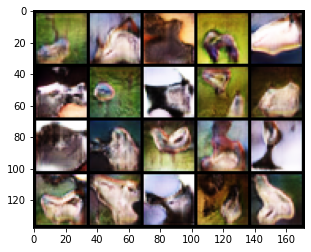

Reconstruction Results 
First two rows are test images, last two rows are corresponding recunstruction results


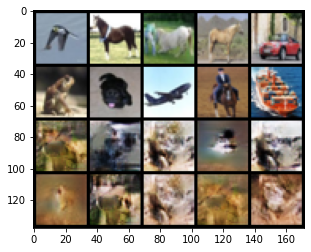

In [7]:
gen_images = model.gen_from_noise(size = (20, model_params['decoder']['latent_dim']))
t_data, _ = iter(test_loader).next()
t_data = t_data.to(device)
_ , rec_t_data = model(t_data)

print("Sampling Results")
show_img(gen_images,step = 1, num_images=25, size=(3, 32, 32), show=True)
print("Reconstruction Results \nFirst two rows are test images, last two rows are corresponding recunstructions")
show_img_rec(t_data, rec_t_data, num_images=10, size=(3, 32, 32),  show=True)

## Quantitative Results

<p align="center"><img src="figures/quantitative.png" alt="Experimental Goal" style="height: 400px; width:300px;"/></p>
<p align="center">Official Results from Paper</p>



**`Our Goal:`** Quantitatively, from Table 2, FID score of DC-VAE Sampling (ours) line on CIFAR-10 dataset will be reproduced.